# Time Series Anomaly Detection

In [5]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import env

**Load Data**

In [6]:
url = env.get_db_access("curriculum_logs")

query = """
SELECT date,
       path as endpoint,
       user_id,
       cohort_id,
       ip as source_ip
FROM logs;
"""
df = pd.read_sql(query, url)
print(df.shape)
df.head()

(900223, 5)


,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


**Clean data**

In [8]:
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)
pages = df['endpoint'].resample('d').count()
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

<Axes: xlabel='date'>

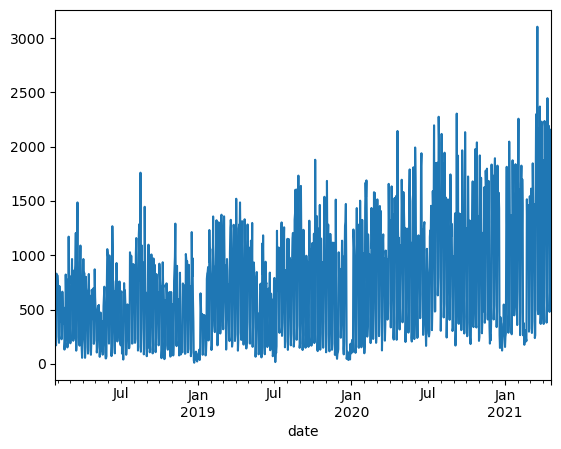

In [9]:
pages.plot()

## Exponential Moving Average

**Span different timelines**

In [14]:
# 7 day EMA
ema_7d = pages.ewm(span=7).mean()
# 14 day EMA
ema_14d = pages.ewm(span=14).mean()
# 30 day EMA
ema_30d = pages.ewm(span=30).mean()
# 90 day EMA
ema_90d = pages.ewm(span=90).mean()
ema_90d.head()

date
2018-01-26    572.000000
2018-01-27    399.100000
2018-01-28    321.030081
2018-01-29    452.545042
2018-01-30    494.228442
Freq: D, Name: endpoint, dtype: float64

**plot EMAs agains each other**

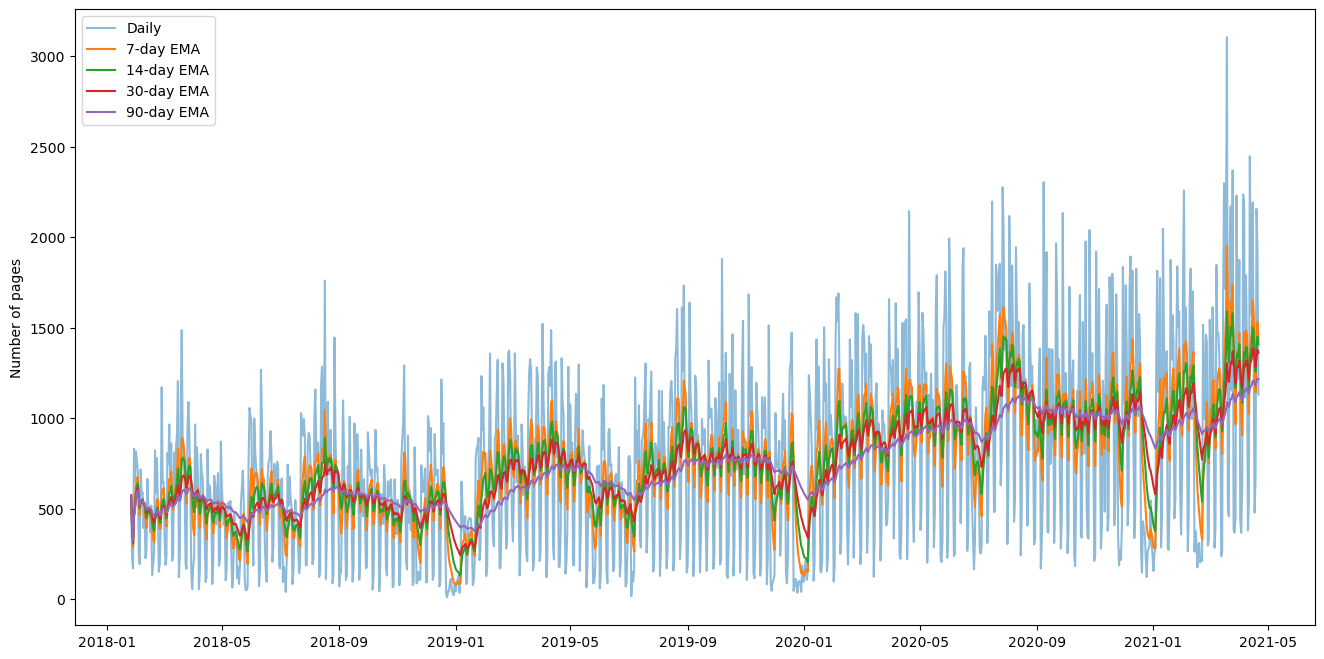

In [15]:
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

**EMA reaction to changes in value**

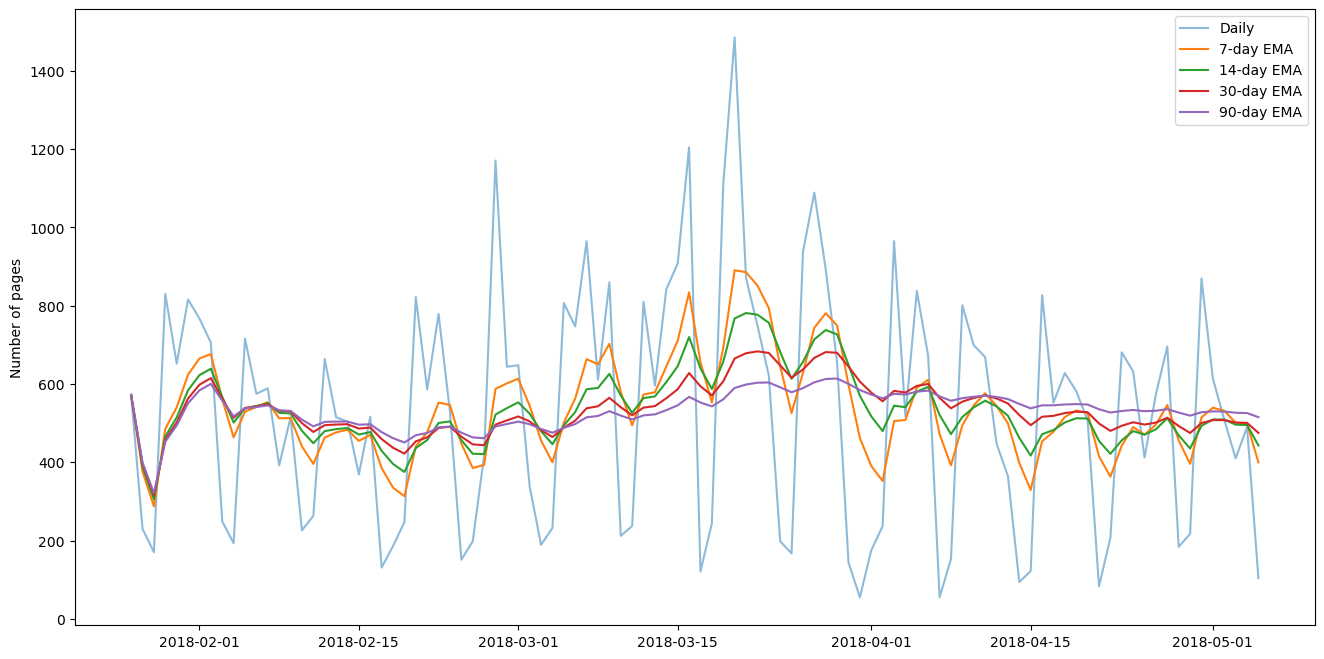

In [16]:
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(pages.index[:100], pages[:100], label='Daily', alpha=.5)
ax.plot(pages.index[:100], ema_7d[:100], label = '7-day EMA')
ax.plot(pages.index[:100], ema_14d[:100], label = '14-day EMA')
ax.plot(pages.index[:100], ema_30d[:100], label = '30-day EMA')
ax.plot(pages.index[:100], ema_90d[:100], label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

## Bollinger Bands using best span

In [19]:
# set the window span
span = 30

# compute midband
midband = pages.ewm(span=span).mean()
# compute exponential stdev
stdev = pages.ewm(span=span).std()
stdev.head()

date
2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    213.878138
2018-01-29    316.467837
2018-01-30    284.479727
Freq: D, Name: endpoint, dtype: float64

In [39]:
# compute upper and lower bands
ub = midband + stdev*2
lb = midband - stdev*2
ub.head(), lb.head()

(date
 2018-01-26            NaN
 2018-01-27     878.961038
 2018-01-28     742.895854
 2018-01-29    1089.938060
 2018-01-30    1070.328518
 Freq: D, Name: endpoint, dtype: float64,
 date
 2018-01-26           NaN
 2018-01-27    -88.361038
 2018-01-28   -112.616698
 2018-01-29   -175.933288
 2018-01-30    -67.590389
 Freq: D, Name: endpoint, dtype: float64)

In [40]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)
bb.columns = ['ub', 'lb']

my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'ub', 'lb']
my_df.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,878.961038,-88.361038
2018-01-28,170,315.139578,742.895854,-112.616698
2018-01-29,830,457.002386,1089.938060,-175.933288
2018-01-30,652,501.369064,1070.328518,-67.590389


**Plot the created bands**

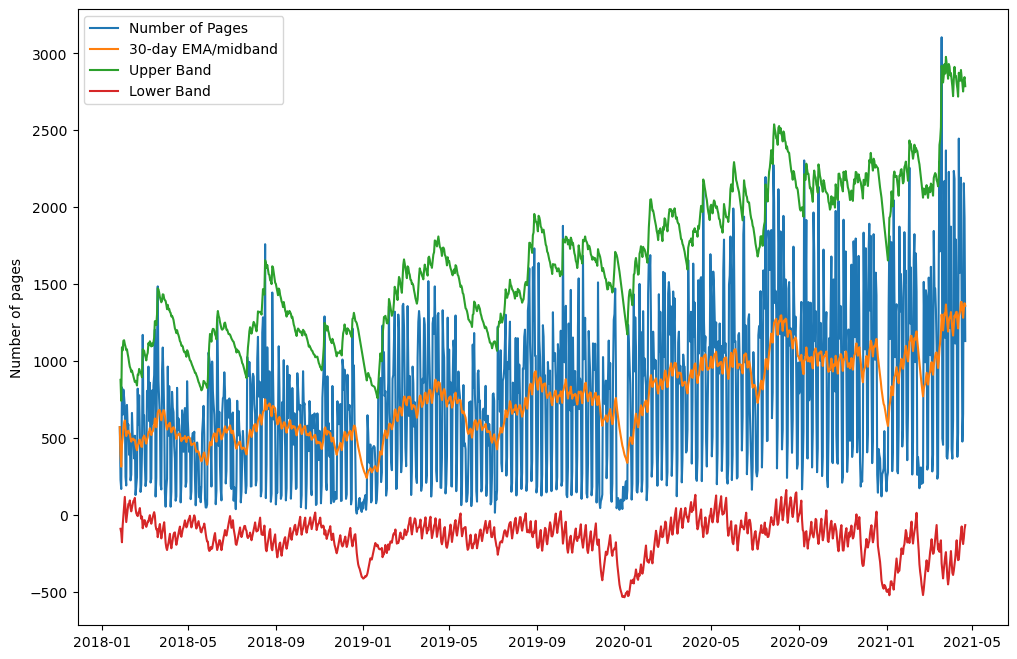

In [41]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

**Compute %b (locate the poin on the Boiliner)**

Each data point will have a %b value that represents its relative position within/around the bollinger bands. It answers the question: Where does this point sit relative to a simple range of expected values?

In [42]:
# Visualize the last record in our dataset
my_df.iloc[-1]

pages      1131.000000
midband    1360.876954
ub         2786.355225
lb          -64.601316
Name: 2021-04-21 00:00:00, dtype: float64

In [43]:
# locate the poin on the bollinger band
last_lb = my_df.iloc[-1].lb
last_ub = my_df.iloc[-1].ub


# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

print('%b for last datapoint: ', round(last_pct_b, 2))

%b for last datapoint:  0.42


**Add column to show location of point on bollinger**

In [45]:
my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
my_df.head()

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,878.961038,-88.361038,0.329116
2018-01-28,170,315.139578,742.895854,-112.616698,0.330348
2018-01-29,830,457.002386,1089.938060,-175.933288,0.794657
2018-01-30,652,501.369064,1070.328518,-67.590389,0.632374
